<a href="https://colab.research.google.com/github/therokitoki/AA2_TP_Alsop-Hachen-Nemeth/blob/main/Ejercicio%203/ejercicio3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Practico AAII

Alumnos: Agustín Alsop, Rocío Hachen, Ulises Nemeth

# Ejercicio 3

## Descripción:
En este problema, se proporciona un conjunto de datos que contiene imágenes de escenas naturales de todo el mundo. El objetivo es construir un modelo de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar estas imágenes en una de las seis categorías predefinidas.

## Dataset:
https://drive.google.com/file/d/1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ/view?usp=drive_link

El dataset proporcionado contiene alrededor de 25,000 imágenes de tamaño 150x150, distribuidas en seis categorías:

> - buildings
> - forest
> - glacier
> - mountain
> - sea
> - street

Las imágenes están divididas en tres conjuntos:
- Train: Alrededor de 14,000 imágenes para entrenamiento.
- Test: Alrededor de 3,000 imágenes para evaluación del modelo.
- Prediction: Alrededor de 7,000 imágenes para predicción final.

## Objetivo:
Utilizando el dataset proporcionado, el objetivo es construir y comparar el rendimiento de distintos modelos de clasificación de imágenes utilizando redes neuronales convolucionales y densas que puedan clasificar con precisión las imágenes de escenas naturales en una de las seis categorías mencionadas anteriormente.


Los modelos a diseñar son:
- Modelo con capas densas.
- Modelo con capas convolucionales y densas.
- Modelo que incluya bloques residuales identidad.
- Modelo que utilice como backbone alguna de las arquitecturas disponibles en TensorFlow (transfer learning).


Se debe entrenar y evaluar cada modelo utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.


# Librerias

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
import os
import re

# Para trabajar con Redes Neuronales
import tensorflow as tf
from tensorflow.keras.layers import Input, RandomFlip, RandomContrast, RandomTranslation, Flatten, Dropout, Dense, Conv2D, Activation, MaxPooling2D, Rescaling, GlobalAveragePooling2D, BatchNormalization, Add, ReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, auc
import seaborn as sns

In [2]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Funciones

In [3]:
def load_best_model(model_name):
  model_dir = "/content/models"

  # Buscamos el valor de Accuracy
  acc_pattern = re.compile(r'acc([0-9.]+)')

  best_model_file = None
  best_acc = -1.0 # Inicializamos la Accuracy en negativo

  # Iteramos por los modelos y seleccionamos el que tiene la Accuracy más alta
  for filename in os.listdir(model_dir):
      if filename.startswith(model_name) and filename.endswith(".keras"):
          match = acc_pattern.search(filename)
          if match:
              acc = float(match.group(1).strip('.'))
              if acc > best_acc:
                  best_acc = acc
                  best_model_file = filename
  if best_model_file:
      best_model_path = os.path.join(model_dir, best_model_file)
      print(f"Cargando modelo: {best_model_file} Accuracy={best_acc}")
      best_model = load_model(best_model_path)
      return best_model
  else:
      print("No se encontró el modelo.")
      return None

# Descarga de dataset

In [4]:
!gdown 1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=37657bc2-24aa-4e90-84da-38cfd9e945c0
To: /content/TP1-3-natural-scenes.zip
100% 363M/363M [00:05<00:00, 63.7MB/s]


In [5]:
zip_path = '/content/TP1-3-natural-scenes.zip'
extract_path = 'unzipped_files'

os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Preparación de datos

In [6]:
# Directorio de los datos
TRAIN_DATA_DIRECTORY = Path("/content/unzipped_files/seg_train/seg_train")
VALIDATION_DATA_DIRECTORY = Path("/content/unzipped_files/seg_test/seg_test")
TEST_DATA_DIRECTORY = Path("/content/unzipped_files/seg_pred")

# Tamaño del lote (batch size)
BATCH_SIZE = 32

# Tamaño de las imágenes
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 7301 files belonging to 1 classes.


Visualizamos los nombres de las clases, y algunas de las imágenes del dataset

# Análisis exploratorio

En este ejercicio estamos trabajando con un dataset que contiene imágenes de distintos lugares. Debajo podemos observar que contiene 6 clases: edificios/construcciones, bosques, glaciares, montañas, mar y calles.

In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Número de clases: {num_classes}")
print(class_names)

Número de clases: 6
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


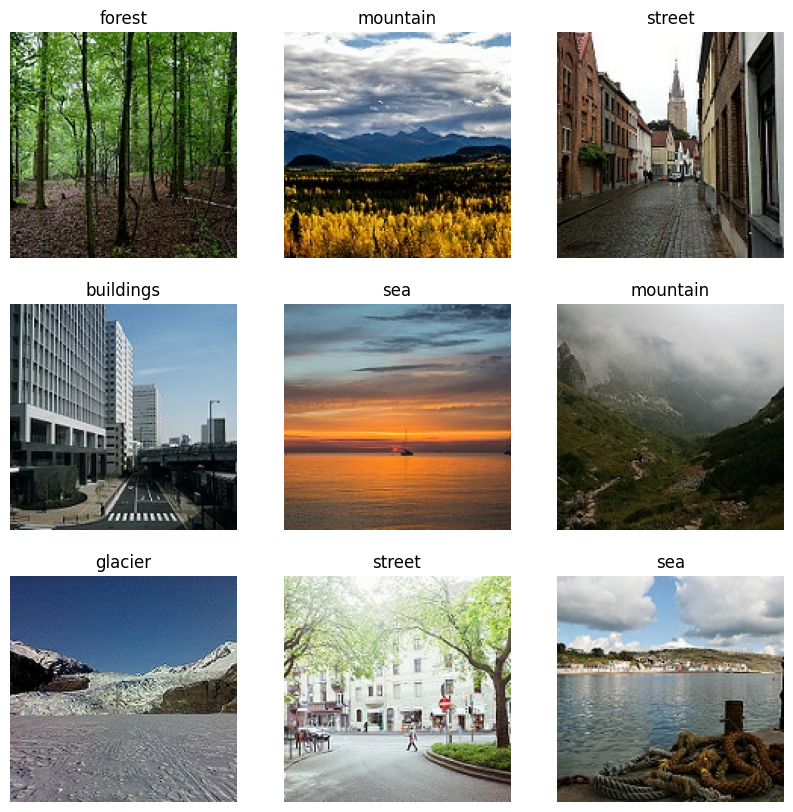

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

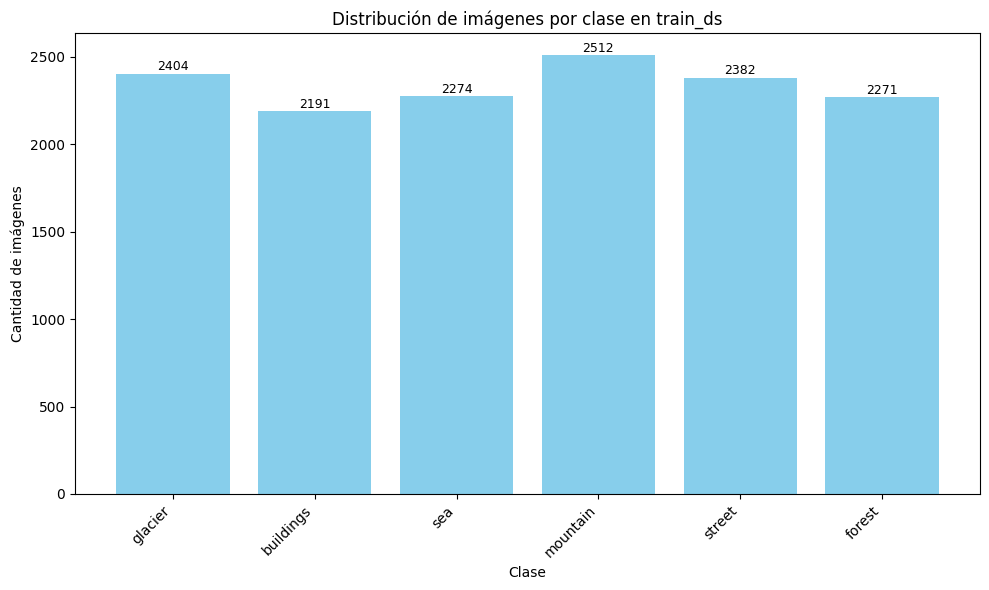

In [9]:
# Contamos cuántas imágenes hay de cada clase
cant_clases = {}
for images, labels in train_ds:
    for label in labels:
        class_idx = np.argmax(label)
        class_name = class_names[class_idx]
        if class_name in cant_clases:
            cant_clases[class_name] += 1
        else:
            cant_clases[class_name] = 1

# Visualizamos
plt.figure(figsize=(10, 6))
bars = plt.bar(cant_clases.keys(), cant_clases.values(), color='skyblue')
plt.xlabel("Clase")
plt.ylabel("Cantidad de imágenes")
plt.title("Distribución de imágenes por clase en train_ds")
plt.xticks(rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, str(int(yval)),
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Podemos observar que el dataset se encuentra balanceado, ya que cada clase tiene alrededor de 2300 imagenes

# Modelos

In [10]:
model_save_path = "/content/models/"

## Modelo con capas densas

In [11]:
checkpoint_acc_dense = ModelCheckpoint(
    model_save_path + "model-dense-{epoch:02d}-acc{val_accuracy:.3f}.keras",
    save_best_only=True,
    monitor="val_accuracy",
    initial_value_threshold=0.4,
    mode="max",
)

### Definición del modelo

In [12]:
model_dense = Sequential([
    Rescaling(1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dense(6, activation='softmax')
    ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compilación

In [13]:
# Compilación
model_dense.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [14]:
model_dense.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    34,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,693,382 (132.34 MB)

 Trainable params: 34,693,382 (132.34 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

In [15]:
EPOCHS= 20

# Entrenamiento
history = model_dense.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_acc_dense]
    )

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.2929 - loss: 8.0729 - val_accuracy: 0.3310 - val_loss: 1.5751
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.3389 - loss: 1.5788 - val_accuracy: 0.3977 - val_loss: 1.4996
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3583 - loss: 1.5312 - val_accuracy: 0.2870 - val_loss: 1.6254
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.2866 - loss: 1.6062 - val_accuracy: 0.2887 - val_loss: 1.6033
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.3206 - loss: 1.5862 - val_accuracy: 0.4080 - val_loss: 1.4868
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3423 - loss: 1.5367 - val_accuracy: 0.3397 - val_loss: 1.5506
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.3337 - loss: 1.5661 - val_accuracy: 0.3473 - val_loss: 1.5853
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3201 - loss: 1.5931 - val

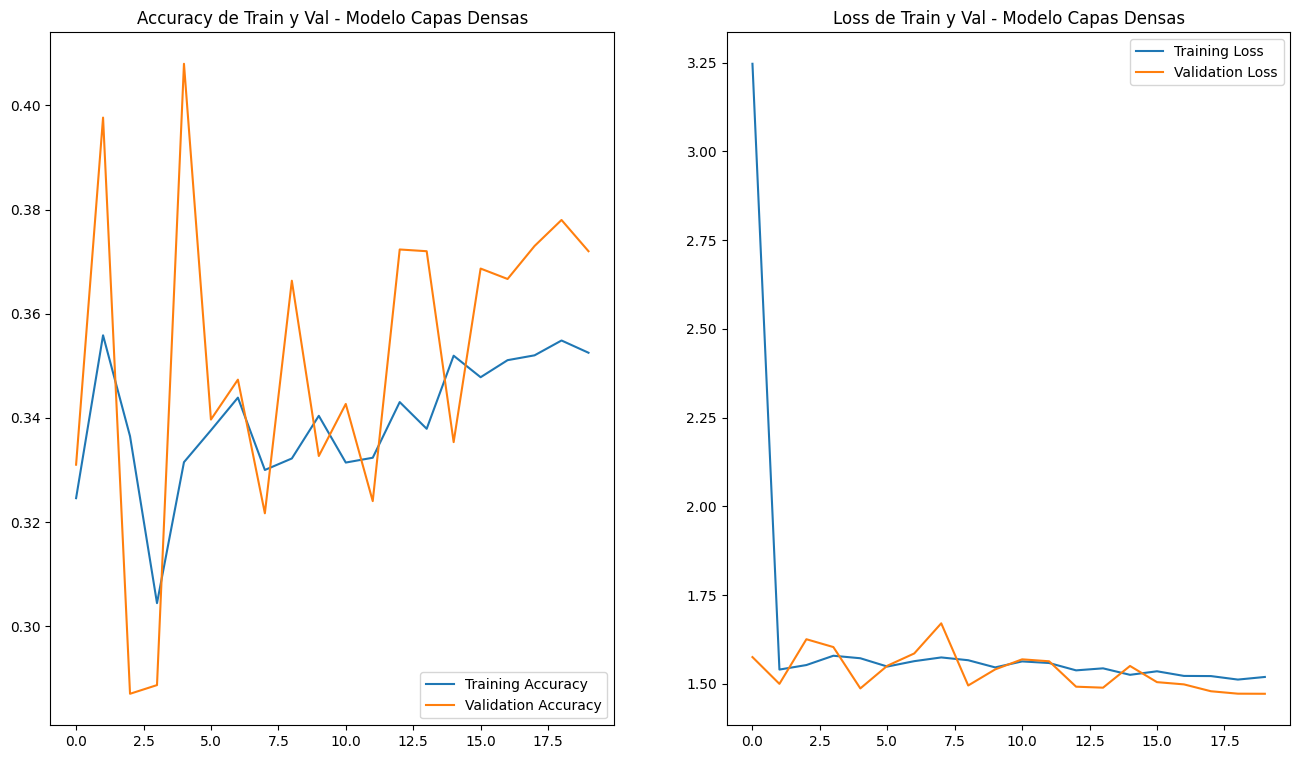

In [16]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy de Train y Val - Modelo Capas Densas')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss de Train y Val - Modelo Capas Densas')
plt.show()

Podemos observar oscilaciones bruscas en la gráfica de Accuracy. Esto se debe a que al no usar capas convolucionales, el modelo está aprendiendo con mayor dificultad, y esto hace que cada epoch varíe drásticamente dependiendo del batch.

Algo notorio es que el modelo suele tener su pico de val-accuracy en la 2da o 3era época.

### Predicción y matriz de confusión

In [43]:
# Carga del mejor modelo
model_dense = load_best_model("model-dense")

Cargando modelo: model-dense-05-acc0.408.keras Accuracy=0.408


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


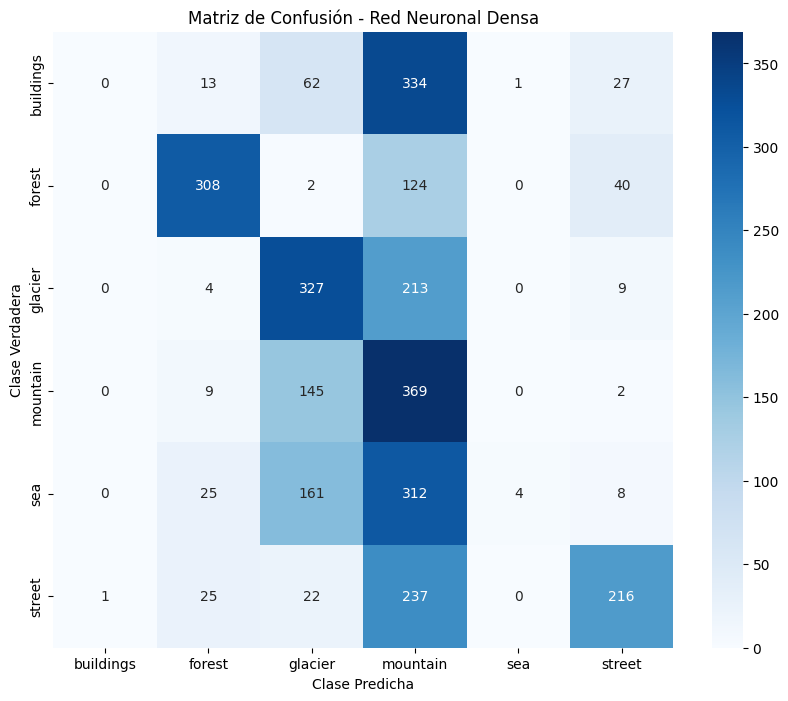


Reporte de Clasificación:
              precision    recall  f1-score   support

   buildings       0.00      0.00      0.00       437
      forest       0.80      0.65      0.72       474
     glacier       0.45      0.59      0.51       553
    mountain       0.23      0.70      0.35       525
         sea       0.80      0.01      0.02       510
      street       0.72      0.43      0.54       501

    accuracy                           0.41      3000
   macro avg       0.50      0.40      0.36      3000
weighted avg       0.51      0.41      0.36      3000



In [44]:
# Predicciones sobre el conjunto de validación
y_pred_probs = model_dense.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []
for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión - Red Neuronal Densa')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


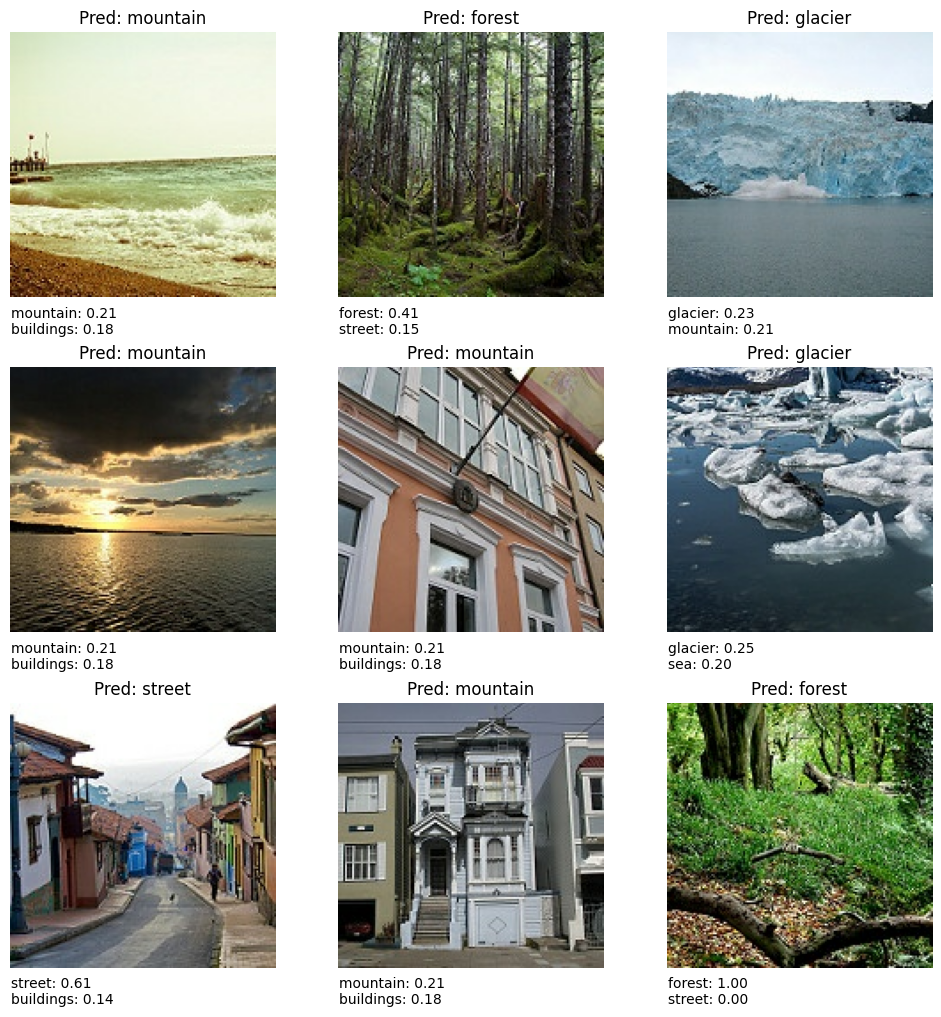

In [45]:
# Obtener 9 imágenes del test
images = []
for img_batch, _ in test_ds.take(1):  # Tomamos un batch del test_ds
    images = img_batch.numpy()[:9]  # Tomamos las primeras 9
    break

# Predicción
preds = model_dense.predict(images)
predicted_labels = np.argmax(preds, axis=1)

# Mostrar
plt.figure(figsize=(10, 30))
for i in range(9):
    plt.subplot(9, 3, i+1)
    plt.imshow(images[i].astype("uint8"))
    class_index = predicted_labels[i]
    class_label = class_names[class_index]

    top2_indices = np.argsort(preds[i])[::-1][:2]

    label1 = f"{class_names[top2_indices[0]]}: {preds[i][top2_indices[0]]:.2f}"
    label2 = f"{class_names[top2_indices[1]]}: {preds[i][top2_indices[1]]:.2f}"

    confidence = preds[i][class_index] * 100  # Calculamos dentro del loop
    plt.title(f"Pred: {class_label}", fontsize=12)
    plt.text(0, 170, f"{label1}\n{label2}", fontsize=10, color='black')
    plt.axis("off")
plt.tight_layout()
plt.show()

### Conclusiones

Los modelos que se componen únicamente de capas densas se encuentran ya de por sí limitados al trabajar con datos de imágenes. Esto se debe a que la imagen se aplana al comienzo y se pierden los datos espaciales.

Nuestra primera red de capas densas, que era muy simple `(Flatten → Dense(16, relu) → Dense(6, softmax))` obtenía una Accuracy de apenas `0.18`, lo cual apenas supera al azar (100%/6 = 16.6%).

Intentamos sumar capas ocultas, neuronas y dropouts para evitar el overfitting, lo cual mejoró el Accuracy hasta `0.33`. De todos modos, esto sigue siendo un Accuracy bajo; nuestra conclusión es que un modelo de capas densas no es una solución efectiva para este tipo de problema.

Se podría utilizar este tipo de red como un modelo base, que nos ayude a determinar el rendimiento minimo que deberían tener nuestras redes convolucionales.

## Modelo con capas convolucionales y densas

In [19]:
checkpoint_acc_conv = ModelCheckpoint(
    model_save_path + "model-conv-{epoch:02d}-acc{val_accuracy:.3f}.keras",
    save_best_only=True,
    monitor="val_accuracy",
    initial_value_threshold=0.8,
    mode="max",
)

### Definición del modelo

In [20]:
# Definición del modelo
model_conv = Sequential([
    Rescaling(1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    RandomFlip("horizontal"),
    RandomFlip("vertical"),
    RandomTranslation(0.1, 0.1, fill_mode="reflect"),
    RandomContrast(0.2),

    Conv2D(8, (3, 3)),
    Activation("relu"),
    Conv2D(16, (3, 3)),
    Activation("relu"),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3)),
    Activation("relu"),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3)),
    Activation("relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(16, activation="relu"),
    Dense(6, activation="softmax")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compilación

In [21]:
# Compilación
model_conv.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [22]:
model_conv.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 150, 150, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 150, 150, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 148, 148, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 146, 146, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 71, 71, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 35, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 33, 33, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │       262,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,790 (1.09 MB)

 Trainable params: 286,790 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

In [23]:
EPOCHS= 20

# Entrenamiento
hist_conv = model_conv.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_acc_conv]
    )

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.3825 - loss: 1.4227 - val_accuracy: 0.6063 - val_loss: 0.9769
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.6204 - loss: 0.9625 - val_accuracy: 0.6637 - val_loss: 0.8798
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6831 - loss: 0.8175 - val_accuracy: 0.7417 - val_loss: 0.7111
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7141 - loss: 0.7621 - val_accuracy: 0.7483 - val_loss: 0.6852
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.7418 - loss: 0.6934 - val_accuracy: 0.7440 - val_loss: 0.6932
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.7537 - loss: 0.6592 - val_accuracy: 0.7663 - val_loss: 0.6421
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.7692 - loss: 0.6228 - val_accuracy: 0.7773 - val_loss: 0.6048
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7701 - loss: 0.6179 - 

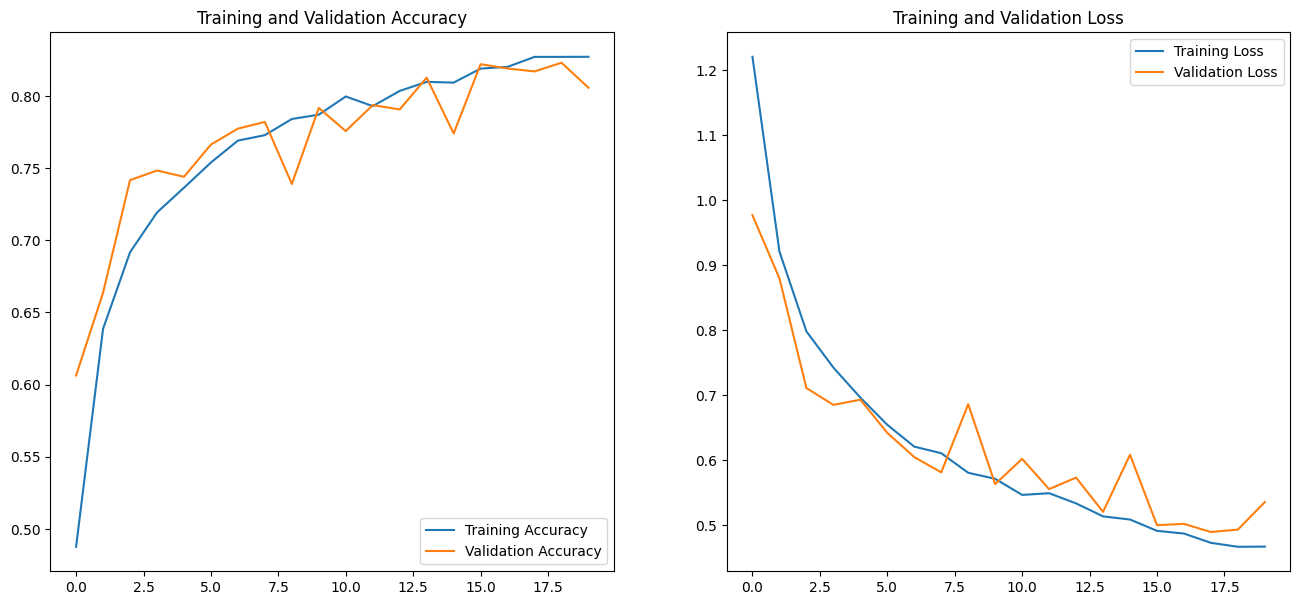

In [24]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = hist_conv.history['accuracy']
val_acc = hist_conv.history['val_accuracy']

loss = hist_conv.history['loss']
val_loss = hist_conv.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predicción y matriz de confusión

El modelo converge bien y mantiene una brecha pequeña entre el entrenamiento y la validación, lo que indica buena capacidad de generalización. No se observa overfitting.

In [46]:
model_conv = load_best_model("model-conv")

Cargando modelo: model-conv-19-acc0.823.keras Accuracy=0.823


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


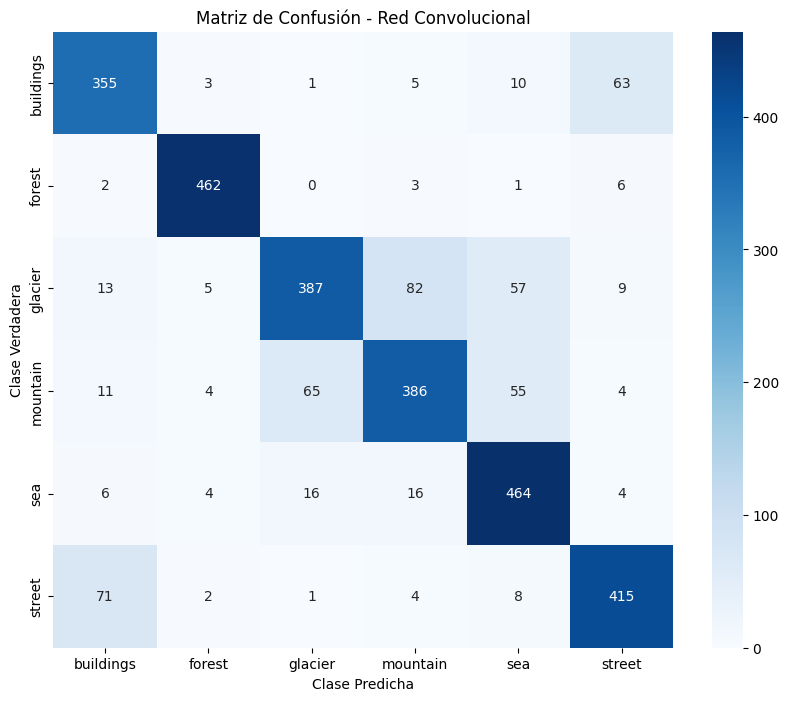


Reporte de Clasificación:
              precision    recall  f1-score   support

   buildings       0.78      0.81      0.79       437
      forest       0.96      0.97      0.97       474
     glacier       0.82      0.70      0.76       553
    mountain       0.78      0.74      0.76       525
         sea       0.78      0.91      0.84       510
      street       0.83      0.83      0.83       501

    accuracy                           0.82      3000
   macro avg       0.82      0.83      0.82      3000
weighted avg       0.82      0.82      0.82      3000



In [47]:
# Predicciones sobre el conjunto de validación
y_pred_probs = model_conv.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []
for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión - Red Convolucional')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


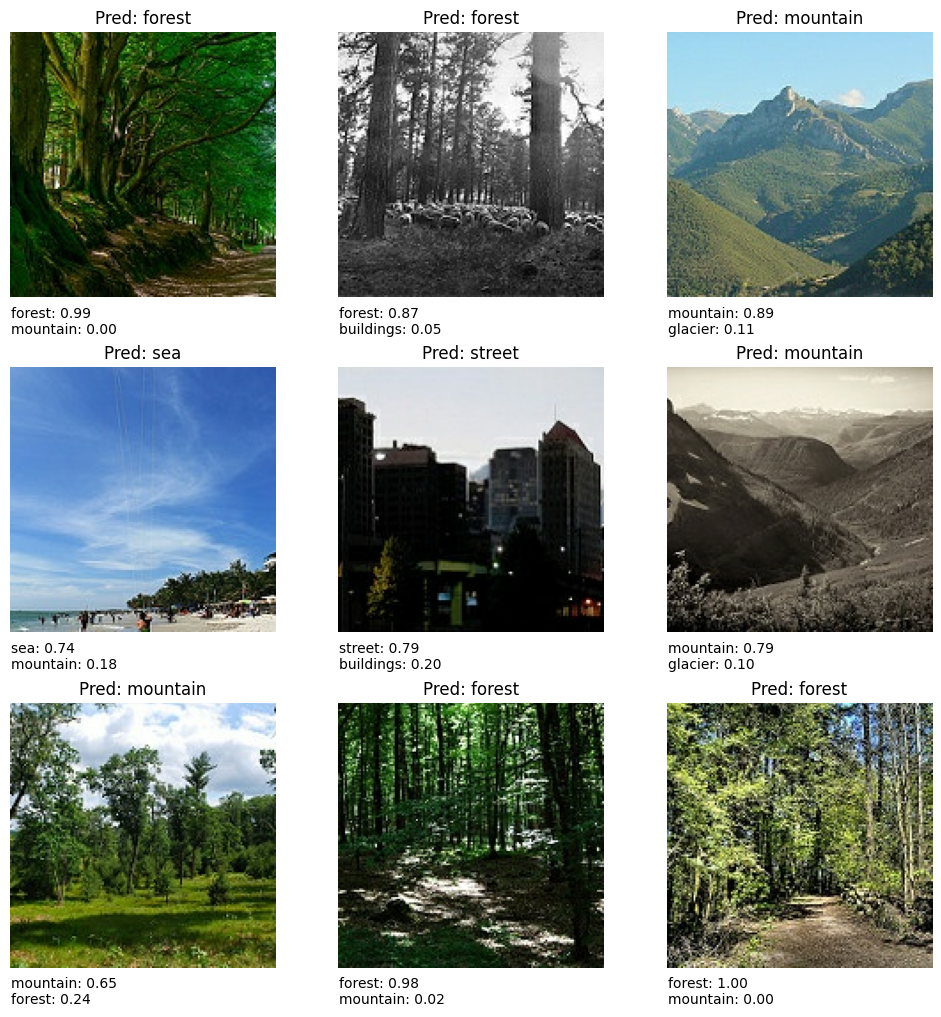

In [48]:
# Obtener 9 imágenes del test
images = []
for img_batch, _ in test_ds.take(1):  # Tomamos un batch del test_ds
    images = img_batch.numpy()[:9]  # Tomamos las primeras 9
    break

# Predicción
preds = model_conv.predict(images)
predicted_labels = np.argmax(preds, axis=1)

# Mostrar
plt.figure(figsize=(10, 30))
for i in range(9):
    plt.subplot(9, 3, i+1)
    plt.imshow(images[i].astype("uint8"))
    class_index = predicted_labels[i]
    class_label = class_names[class_index]

    top2_indices = np.argsort(preds[i])[::-1][:2]

    label1 = f"{class_names[top2_indices[0]]}: {preds[i][top2_indices[0]]:.2f}"
    label2 = f"{class_names[top2_indices[1]]}: {preds[i][top2_indices[1]]:.2f}"

    confidence = preds[i][class_index] * 100  # Calculamos dentro del loop
    plt.title(f"Pred: {class_label}", fontsize=12)
    plt.text(0, 170, f"{label1}\n{label2}", fontsize=10, color='black')
    plt.axis("off")
plt.tight_layout()
plt.show()

### Conclusiones

El uso de capas convolucionales le permite al modelo aprender patrones visuales significativos y generalizar correctamente. Este modelo es claramente superior al modelo de capas densas, con una accuracy de ~83%

Además de la combinación base de capas convolucionales, capas ReLu y Maxpooling, se incorporó *Normalización* y *Data Augmentation* por medio de los RandomFlip, RandomTranslation y RandomContrast, los cuales ayudan al modelo a generalizar mejor.

## Modelo con Transfer Learning

En este caso realizaremos Transfer Learning con el modelo pre-entrenado MobileNetV2

In [27]:
checkpoint_acc_transfer = ModelCheckpoint(
    model_save_path + "model-transfer-{epoch:02d}-acc{val_accuracy:.3f}.keras",
    save_best_only=True,
    monitor="val_accuracy",
    initial_value_threshold=0.8,
    mode="max",
)

### Definición de modelo

In [28]:
# Modelo base ya entrenado
base_model = MobileNetV2(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
                         include_top=False, weights='imagenet')
base_model.trainable = False  # Congelamos para transfer learning

# Definición del modelo
model_transfer = Sequential([
    Rescaling(1./255 , input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(6, activation="softmax")
])

<ipython-input-28-5a7aa9c3dd51>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compilación

In [29]:
# Compilación
model_transfer.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [30]:
model_transfer.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,614 (8.93 MB)

 Trainable params: 82,502 (322.27 KB)

 Non-trainable params: 2,258,112 (8.61 MB)

### Entrenamiento

In [31]:
EPOCHS = 20

# Entrenamiento
history_transfer = model_transfer.fit(train_ds,
                             validation_data=val_ds,
                             epochs=EPOCHS,
                             batch_size=BATCH_SIZE,
                             callbacks=[checkpoint_acc_transfer])

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - accuracy: 0.8035 - loss: 0.5515 - val_accuracy: 0.8890 - val_loss: 0.3022
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.8974 - loss: 0.2865 - val_accuracy: 0.9017 - val_loss: 0.2665
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9063 - loss: 0.2615 - val_accuracy: 0.9017 - val_loss: 0.2688
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9177 - loss: 0.2350 - val_accuracy: 0.8983 - val_loss: 0.2759
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9198 - loss: 0.2260 - val_accuracy: 0.9063 - val_loss: 0.2606
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9231 - loss: 0.2084 - val_accuracy: 0.9080 - val_loss: 0.2503
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9291 - loss: 0.1983 - val_accuracy: 0.8970 - val_loss: 0.2809
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9339 - loss: 0.1893 - val_

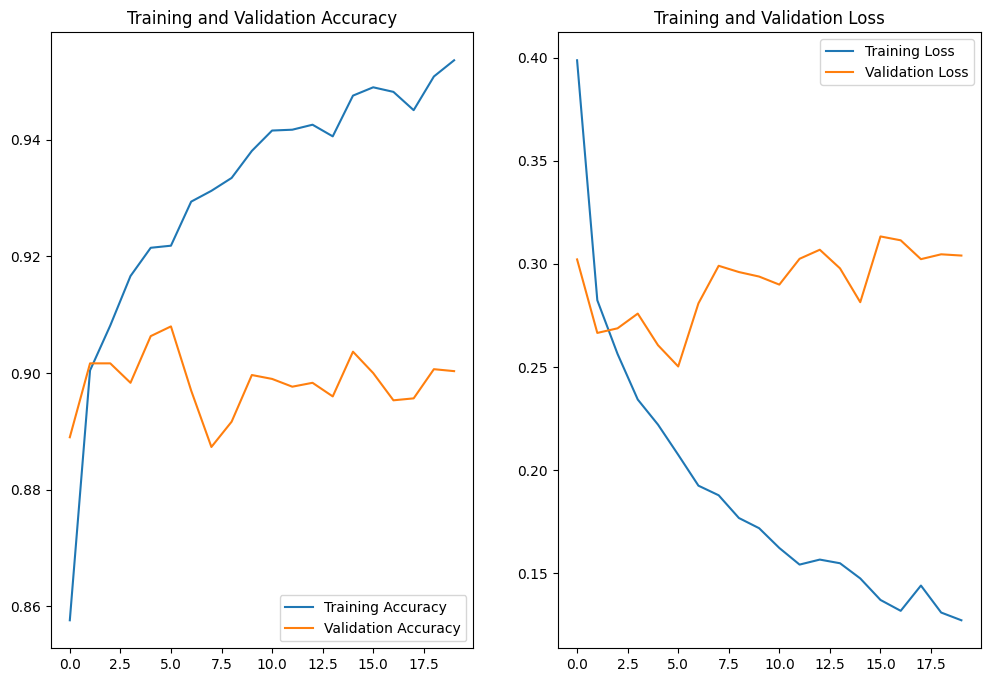

In [32]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_transfer.history['accuracy']
val_acc = history_transfer.history['val_accuracy']

loss = history_transfer.history['loss']
val_loss = history_transfer.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Pareciera observarse una gran diferencia entre la curva de Train y Validation, lo que podría indicar overfitting, sin embargo la direfencia es de unos 9 puntos, entre 90% y 99%

### Predicción y matriz de confusión

In [49]:
model_transfer = load_best_model("model-transfer")

Cargando modelo: model-transfer-06-acc0.908.keras Accuracy=0.908


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


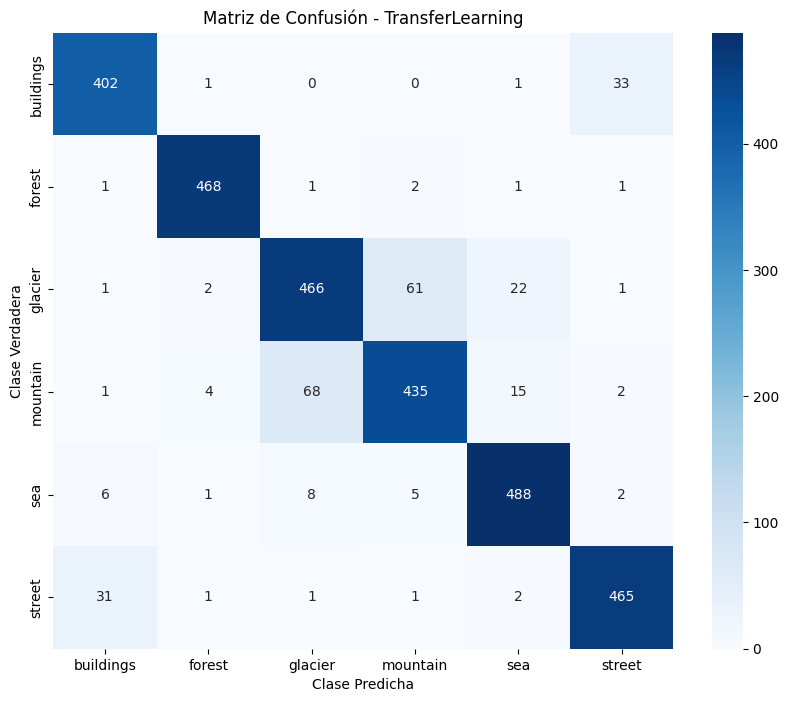


Reporte de Clasificación:
              precision    recall  f1-score   support

   buildings       0.91      0.92      0.91       437
      forest       0.98      0.99      0.98       474
     glacier       0.86      0.84      0.85       553
    mountain       0.86      0.83      0.85       525
         sea       0.92      0.96      0.94       510
      street       0.92      0.93      0.93       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



In [51]:
# Predicciones sobre el conjunto de validación
y_pred_probs = model_transfer.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []
for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión - TransferLearning')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


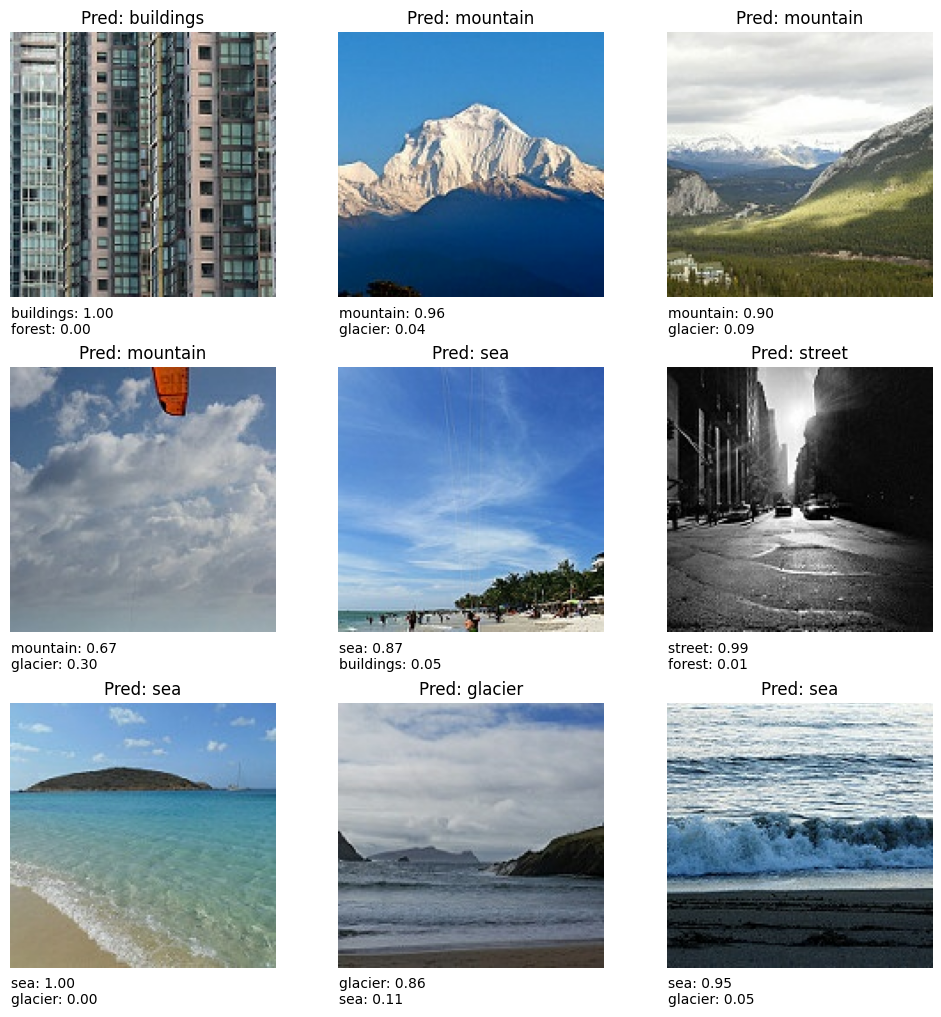

In [52]:
# Obtener 9 imágenes del test
images = []
for img_batch, _ in test_ds.take(1):  # Tomamos un batch del test_ds
    images = img_batch.numpy()[:9]  # Tomamos las primeras 9
    break

# Predicción

preds = model_transfer.predict(images)
predicted_labels = np.argmax(preds, axis=1)

# Mostrar
plt.figure(figsize=(10, 30))
for i in range(9):
    plt.subplot(9, 3, i+1)
    plt.imshow(images[i].astype("uint8"))
    class_index = predicted_labels[i]
    class_label = class_names[class_index]

    top2_indices = np.argsort(preds[i])[::-1][:2]

    label1 = f"{class_names[top2_indices[0]]}: {preds[i][top2_indices[0]]:.2f}"
    label2 = f"{class_names[top2_indices[1]]}: {preds[i][top2_indices[1]]:.2f}"

    confidence = preds[i][class_index] * 100  # Calculamos dentro del loop
    plt.title(f"Pred: {class_label}", fontsize=12)
    plt.text(0, 170, f"{label1}\n{label2}", fontsize=10, color='black')
    plt.axis("off")
plt.tight_layout()
plt.show()

## Modelo Residual

Nuestro modelo residual utilizará bloques identidad que siguen la siguiente arquitectura

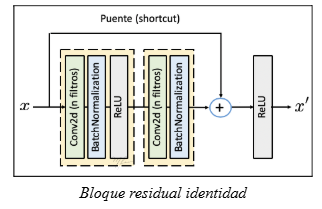

In [35]:
checkpoint_acc_resnet = ModelCheckpoint(
    model_save_path + "model-resnet-{epoch:02d}-acc{val_accuracy:.3f}.keras",
    save_best_only=True,
    monitor="val_accuracy",
    initial_value_threshold=0.8,
    mode="max",
)

### Definición del modelo

In [36]:
# Bloque residual identidad

def identity_block(x, filters):
    shortcut = x  # input is used directly as shortcut

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

In [37]:
def res_net(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Rescaling(1./255)(inputs)

    # Data augmentation
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = ReLU()(x)

    x = identity_block(x, 32)
    x = identity_block(x, 32)
    x = identity_block(x, 32)

    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

### Compilación

In [38]:
model_resnet = res_net((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Entrenamiento

In [39]:
EPOCHS = 20

history_resnet = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_acc_resnet])

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 125s 268ms/step - accuracy: 0.5305 - loss: 1.1925 - val_accuracy: 0.5333 - val_loss: 1.1442
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 117s 266ms/step - accuracy: 0.6945 - loss: 0.7977 - val_accuracy: 0.6287 - val_loss: 0.9594
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 121s 276ms/step - accuracy: 0.7334 - loss: 0.7059 - val_accuracy: 0.4930 - val_loss: 1.3919
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 142s 276ms/step - accuracy: 0.7538 - loss: 0.6574 - val_accuracy: 0.6933 - val_loss: 0.7767
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 142s 276ms/step - accuracy: 0.7740 - loss: 0.5994 - val_accuracy: 0.6850 - val_loss: 0.8424
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 138s 266ms/step - accuracy: 0.7835 - loss: 0.5787 - val_accuracy: 0.5217 - val_loss: 1.3847
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 121s 276ms/step - accuracy: 0.7880 - loss: 0.5599 - val_accuracy: 0.7677 - val_loss: 0.6246
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 117s 266ms/step - accuracy: 0.7979 -

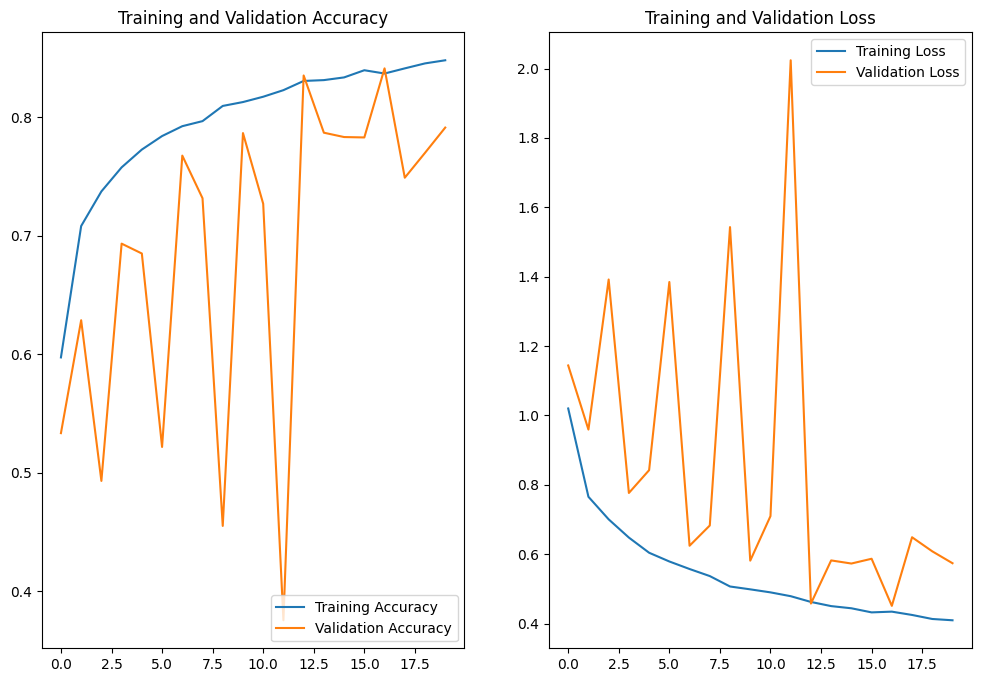

In [40]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']

loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predicción y matriz de confusión

In [53]:
model_resnet = load_best_model("model-resnet")

Cargando modelo: model-resnet-17-acc0.841.keras Accuracy=0.841


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step


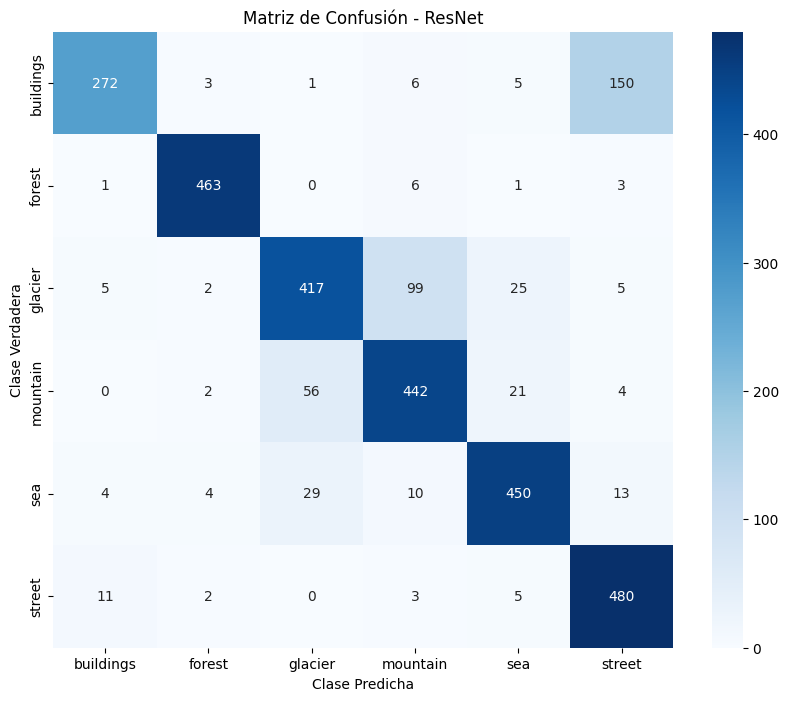


Reporte de Clasificación:
              precision    recall  f1-score   support

   buildings       0.93      0.62      0.75       437
      forest       0.97      0.98      0.97       474
     glacier       0.83      0.75      0.79       553
    mountain       0.78      0.84      0.81       525
         sea       0.89      0.88      0.88       510
      street       0.73      0.96      0.83       501

    accuracy                           0.84      3000
   macro avg       0.86      0.84      0.84      3000
weighted avg       0.85      0.84      0.84      3000



In [54]:
# Predicciones sobre el conjunto de validación
y_pred_probs = model_resnet.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []
for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión - ResNet')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


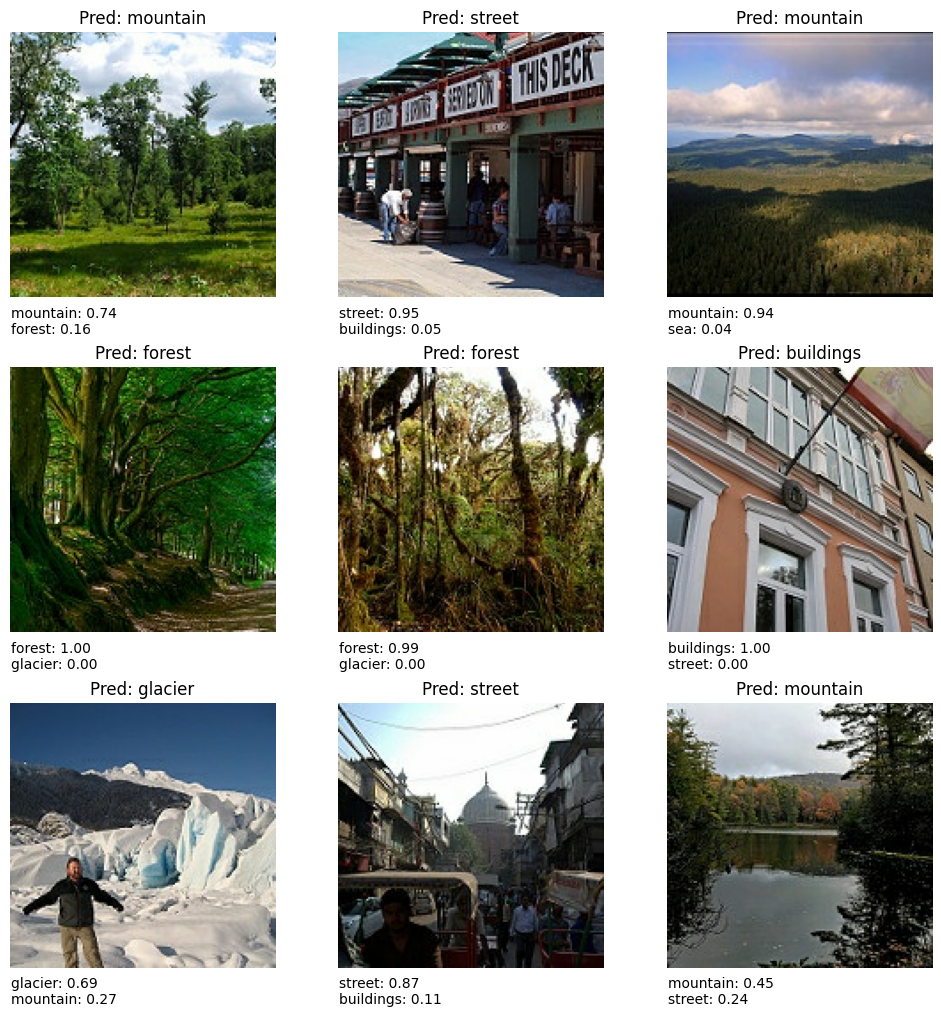

In [55]:
# Obtener 9 imágenes del test
images = []
for img_batch, _ in test_ds.take(1):  # Tomamos un batch del test_ds
    images = img_batch.numpy()[:9]  # Tomamos las primeras 9
    break

# Predicción
preds = model_resnet.predict(images)
predicted_labels = np.argmax(preds, axis=1)

# Mostrar
plt.figure(figsize=(10, 30))
for i in range(9):
    plt.subplot(9, 3, i+1)
    plt.imshow(images[i].astype("uint8"))
    class_index = predicted_labels[i]
    class_label = class_names[class_index]

    top2_indices = np.argsort(preds[i])[::-1][:2]

    label1 = f"{class_names[top2_indices[0]]}: {preds[i][top2_indices[0]]:.2f}"
    label2 = f"{class_names[top2_indices[1]]}: {preds[i][top2_indices[1]]:.2f}"

    confidence = preds[i][class_index] * 100  # Calculamos dentro del loop
    plt.title(f"Pred: {class_label}", fontsize=12)
    plt.text(0, 170, f"{label1}\n{label2}", fontsize=10, color='black')
    plt.axis("off")
plt.tight_layout()
plt.show()

# Comparación de modelos